In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [2]:
df = pd.read_csv('gene_expression.csv')
df.head()
# gen durumlarına göre kanser mi değil mi. 1 kanser, 0 sağlıklı gen

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


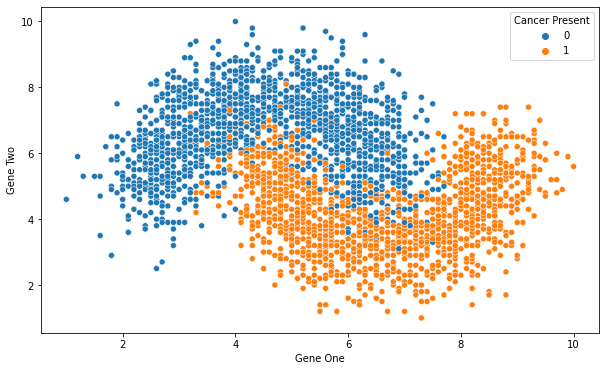

In [4]:
sns.scatterplot(x = df["Gene One"], y = df["Gene Two"], hue= df["Cancer Present"]);

In [5]:
df["Cancer Present"].value_counts()

1    1500
0    1500
Name: Cancer Present, dtype: int64

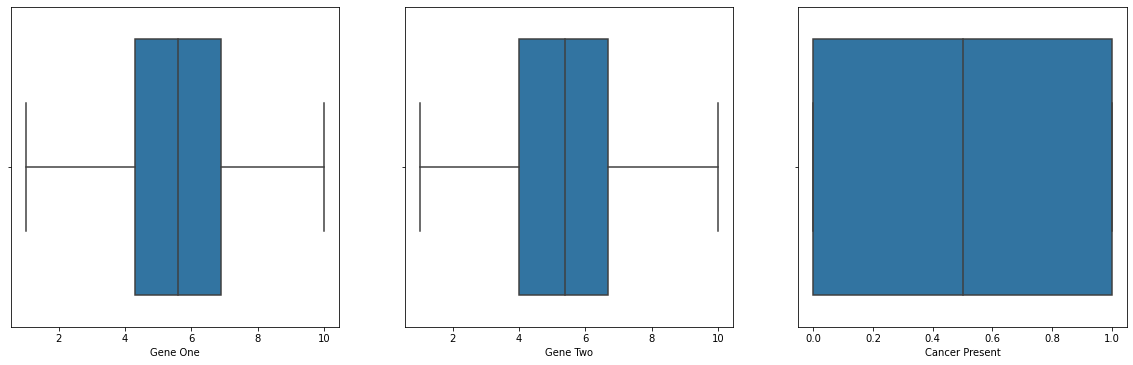

In [6]:
index = 0
plt.figure(figsize=(20,20))
for i in df.select_dtypes([float, int]).columns:
    index += 1
    plt.subplot(3,3,index)
    sns.boxplot(df.select_dtypes([float, int])[i], whis= 1.5)

In [7]:
df.corr()["Cancer Present"].drop("Cancer Present").sort_values()

Gene Two   -0.692352
Gene One    0.545854
Name: Cancer Present, dtype: float64

### Train_Test_Modelling_Scalling : 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Default Modelling : 

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

### Metrics : 

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [13]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
eval_metric(knn_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[306  22]
 [ 27 245]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       328
           1       0.92      0.90      0.91       272

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600


Train_Set
[[1110   62]
 [  68 1160]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1172
           1       0.95      0.94      0.95      1228

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



In [14]:
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
eval_metric(log_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[276  52]
 [ 39 233]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       328
           1       0.82      0.86      0.84       272

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600


Train_Set
[[1006  166]
 [ 174 1054]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1172
           1       0.86      0.86      0.86      1228

    accuracy                           0.86      2400
   macro avg       0.86      0.86      0.86      2400
weighted avg       0.86      0.86      0.86      2400



### Cross Validate Control : 

In [15]:
from sklearn.model_selection import cross_validate

In [16]:

model = KNeighborsClassifier()

scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.926250
test_precision    0.930223
test_recall       0.925890
test_f1           0.927829
dtype: float64

In [17]:
from sklearn.model_selection import cross_validate

model = LogisticRegression()

scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.857083
test_precision    0.863490
test_recall       0.857457
test_f1           0.859908
dtype: float64

### Best k value Elbow Method : 

In [18]:
k_range = range(1,23)

list_dist = []
list_score = []
sayac = 1
for k in k_range : 
    model = KNeighborsClassifier(n_neighbors= k)
    model.fit(X_train_scaled, y_train)
    #print(sayac , "Doğruluk oranı = % ", model.score(X_train_scaled, y_train)*100)
    sayac = sayac + 1
    list_dist.append(sayac-1)
    list_score.append(round(model.score(X_train_scaled, y_train)*100,2))
list_score = pd.DataFrame(list_score)  
list_dist = pd.DataFrame(list_dist)
train_k = pd.concat([list_dist, list_score], axis=1)
train_k.columns = ["k_value_train", "score_train"]
train_k

list_dist1 = []
list_score1 = []
index = 1
for k in k_range : 
    model2 = KNeighborsClassifier(n_neighbors= k)
    model2.fit(X_train_scaled, y_train)
    #print(sayac , "Doğruluk oranı = % ", model.score(X_train_scaled, y_train)*100)
    index = index + 1
    list_dist1.append(index-1)
    list_score1.append(round(model2.score(X_test_scaled, y_test)*100,2))
list_score1 = pd.DataFrame(list_score1)  
list_dist1 = pd.DataFrame(list_dist1)
test_k = pd.concat([list_dist1, list_score1], axis=1)
test_k.columns = ["k_value_test", "score_test"]
scores = pd.concat([test_k, train_k], axis=1)
scores["result"] = scores["score_train"] - scores["score_test"]
scores

,k_value_test,score_test,k_value_train,score_train,result
0,1,90.00,1,97.17,7.17
1,2,90.17,2,94.75,4.58
2,3,92.67,3,95.17,2.50
3,4,92.00,4,94.38,2.38
4,5,91.83,5,94.58,2.75
5,6,92.17,6,94.12,1.95
6,7,92.83,7,94.38,1.55
7,8,92.83,8,94.21,1.38
8,9,93.50,9,94.17,0.67
9,10,93.50,10,94.08,0.58


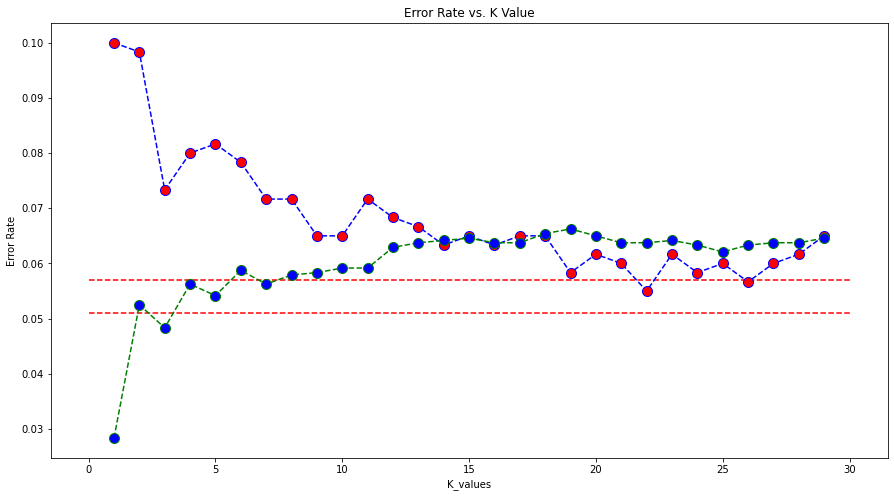

In [19]:
test_error_rates = []
train_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled,y_train) 
   
    y_pred_test = knn_model.predict(X_test_scaled)
    y_pred_train = knn_model.predict(X_train_scaled)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    train_error = 1 - accuracy_score(y_train,y_pred_train)
    test_error_rates.append(test_error)
    train_error_rates.append(train_error)
    
    
plt.figure(figsize=(15,8))
plt.plot(range(1,30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.plot(range(1,30), train_error_rates, color='green', linestyle='--', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.051, xmin = 0, xmax = 30, colors= 'r', linestyles="--")
plt.hlines(y=0.057, xmin = 0, xmax = 30, colors= 'r', linestyles="--")

In [20]:
deneme = KNeighborsClassifier(n_neighbors= 14)
deneme.fit(X_train_scaled, y_train)
eval_metric(deneme, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[312  16]
 [ 22 250]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       328
           1       0.94      0.92      0.93       272

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600


Train_Set
[[1100   72]
 [  82 1146]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1172
           1       0.94      0.93      0.94      1228

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



In [21]:
deneme = KNeighborsClassifier(n_neighbors= 15)
deneme.fit(X_train_scaled, y_train)
eval_metric(deneme, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[309  19]
 [ 20 252]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       328
           1       0.93      0.93      0.93       272

    accuracy                           0.94       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.94      0.93       600


Train_Set
[[1091   81]
 [  74 1154]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1172
           1       0.93      0.94      0.94      1228

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



In [22]:
deneme = KNeighborsClassifier(n_neighbors= 16)
deneme.fit(X_train_scaled, y_train)
eval_metric(deneme, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[312  16]
 [ 22 250]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       328
           1       0.94      0.92      0.93       272

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600


Train_Set
[[1102   70]
 [  83 1145]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1172
           1       0.94      0.93      0.94      1228

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



### GridSearch KNN on Pipeline : 

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### KNN : 

In [30]:
operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]
Pipeline(steps=operations)
pipe_model = Pipeline(steps=operations)

In [32]:
pipe_model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [33]:
k_values = range(1,30)
param_grid = {"knn__n_neighbors":k_values, "knn__p": [1,2], "knn__weights": ['uniform', "distance"]}
pipe_model = Pipeline(steps=operations)
pipe_grid = GridSearchCV(pipe_model, param_grid, cv=10, scoring= 'recall')
pipe_grid.fit(X_train,y_train) # scale edilmemiş halini fit etmek zorundayız.

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(1, 30), 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='recall')

In [34]:
pipe_grid.best_params_

{'knn__n_neighbors': 25, 'knn__p': 1, 'knn__weights': 'uniform'}

### Logistic : 

In [35]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]
Pipeline(steps=operations)
pipe_model = Pipeline(steps=operations)

In [36]:
pipe_model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('logistic', LogisticRegression())],
 'verbose': False,
 'scaler': StandardScaler(),
 'logistic': LogisticRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logistic__C': 1.0,
 'logistic__class_weight': None,
 'logistic__dual': False,
 'logistic__fit_intercept': True,
 'logistic__intercept_scaling': 1,
 'logistic__l1_ratio': None,
 'logistic__max_iter': 100,
 'logistic__multi_class': 'auto',
 'logistic__n_jobs': None,
 'logistic__penalty': 'l2',
 'logistic__random_state': None,
 'logistic__solver': 'lbfgs',
 'logistic__tol': 0.0001,
 'logistic__verbose': 0,
 'logistic__warm_start': False}

In [37]:
logistic__penalty = ["l1", "l2", "elasticnet"] 

logistic__C = np.logspace(-1, 5, 100) 

logistic__class_weight = ["balanced", None] 

logistic__solver = ["lbfgs", "liblinear", "sag", "saga"] 

param_grid = {"logistic__penalty" : logistic__penalty,
              "logistic__C" : logistic__C,
              "logistic__class_weight":logistic__class_weight,
              "logistic__solver":logistic__solver}

grid_model = GridSearchCV(estimator=pipe_model,
                          param_grid=param_grid,
                          cv=10,
                          scoring = "recall", # skor olarak recall al dedik. default olarak 1 olarak hesaplayacak. 
                          n_jobs = -1)

In [38]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logistic__C': array([1.00000000e-01, 1.14975700e-01, 1.32194115e-01, 1.51991108e-01,
       1.74752840e-01, 2.00923300e-01, 2.31012970e-01, 2.65608778e-01,
       3.05385551e-01, 3.51119173e-01, 4.03701726e-01, 4.64158883e-01,
       5.33669923e-01, 6.1...
       1.23284674e+04, 1.41747416e+04, 1.62975083e+04, 1.87381742e+04,
       2.15443469e+04, 2.47707636e+04, 2.84803587e+04, 3.27454916e+04,
       3.76493581e+04, 4.32876128e+04, 4.97702356e+04, 5.72236766e+04,
       6.57933225e+04, 7.56463328e+04, 8.69749003e+04, 1.00000000e+05]),
                         'logistic__class_weight': ['balanced', None],
                         'logistic__penalty': ['l1', 'l2', 'elasticnet'],
                         'logistic__solver': ['lbfgs', 'liblinear', 'sag',
                     

In [39]:
grid_model.best_params_

{'logistic__C': 0.1,
 'logistic__class_weight': None,
 'logistic__penalty': 'l2',
 'logistic__solver': 'lbfgs'}

### Cross Validate : 

In [45]:
operations = [('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=25))]
model = Pipeline(operations)

scores = cross_validate(model, X_train, y_train, scoring = ['precision','recall','f1','accuracy'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_precision    0.934887
test_recall       0.936459
test_f1           0.935443
test_accuracy     0.933750
dtype: float64

In [46]:
operations = [('scaler',StandardScaler()),('log',LogisticRegression(penalty='l2', C=0.1, solver="lbfgs", class_weight= None))]
model = Pipeline(operations)

scores = cross_validate(model, X_train, y_train, scoring = ['precision','recall','f1','accuracy'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_precision    0.863677
test_recall       0.859083
test_f1           0.860821
test_accuracy     0.857917
dtype: float64

### Final Model : 

In [47]:
operations = [('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors = 15, p=1))]
pipe_final = Pipeline(operations)
pipe_final.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=15, p=1))])

### Tahmin edeceğimiz değerler : 

In [48]:
new_obs = {"Gene One": [1, 3, 4.3, 5.6, 7, 9.5, 2, 6],
           "Gene Two": [1, 4, 4, 5.5, 6.7, 10, 8, 1]
          }
samples = pd.DataFrame(new_obs)
samples

,Gene One,Gene Two
0,1.0,1.0
1,3.0,4.0
2,4.3,4.0
3,5.6,5.5
4,7.0,6.7
5,9.5,10.0
6,2.0,8.0
7,6.0,1.0


In [49]:
predictions = pipe_final.predict(samples)
predictions_proba = pipe_final.predict_proba(samples)
samples["pred"] = predictions
samples["pred_proba"] = predictions_proba[:,1]

In [50]:
samples

,Gene One,Gene Two,pred,pred_proba
0,1.0,1.0,0,0.000000
1,3.0,4.0,0,0.066667
2,4.3,4.0,1,1.000000
3,5.6,5.5,0,0.333333
4,7.0,6.7,0,0.000000
5,9.5,10.0,1,0.933333
6,2.0,8.0,0,0.000000
7,6.0,1.0,1,1.000000


In [54]:
data = X.head(7)

In [55]:
pred = pipe_final.predict(data)
pred

array([1, 0, 1, 0, 1, 0, 0], dtype=int64)

In [57]:
data["gercek"] = y.head(7)
data["tahmin"] = pred
data

,Gene One,Gene Two,gercek,tahmin
0,4.3,3.9,1,1
1,2.5,6.3,0,0
2,5.7,3.9,1,1
3,6.1,6.2,0,0
4,7.4,3.4,1,1
5,3.4,7.5,0,0
6,3.1,6.8,0,0
